In [3]:
using SLMTools
using SpecialPolynomials, Distributions, Plots, Images, FFTW, JLD2, LaTeXStrings
using SpecialFunctions: gamma
using SLMTools: wrap, oneShot

In [12]:
Base.copy(f::LF{I}) where I<:FieldVal = LF{I}(copy(f.data),copy(f.L),copy(f.flambda))
Base.:(+)(x::LF{Intensity}, y::LF{Intensity}) = (elq(x, y); LF{Intensity}(x.data .+ y.data, x.L, x.flambda))
lfRect(lft::LF{S,T,N},s::NTuple{N,Real},c::NTuple{N,Real}=Tuple(zeros(N))) where {S,T,N} = 
    LF{S}( (x=zeros(T,size(lft)); x[(abs.(lft.L[i].-c[i]) .< s[i] for i=1:N)...] .= 1; x), lft.L,lft.flambda )

function SchroffError(target::LF{Intensity},reality::LF{Intensity},threshold=0.5)
    mask = (target.data .> threshold*maximum(target.data))
    x = target.data[mask]
    x ./= sum(x)
    y = reality.data[mask]
    y ./= sum(y)
    nPixels = sum(mask)
    return sqrt(sum( (x-y).^2/x.^2 )/nPixels)
end

function boxEfficiency(F::LF{Intensity},roi::CartesianIndices)
    sum(F[roi].data)/sum(F.data)
end
function boxEfficiency(F::LF{<:Amplitude},roi::CartesianIndices)
    boxEfficiency(square(F),roi)
end
function boxEfficiency(F::LF{Intensity},roi::Matrix{Bool})
    sum(F.data[roi])/sum(F.data)
end
function boxEfficiency(F::LF{<:Amplitude},roi::Matrix{Bool})
    boxEfficiency(square(F),roi)
end

# First the 1D Hermite-Gaussian modes. 
function HGmode(n::Integer,x::Number,z::Number,w0::Number,lambda::Number)
    zr = pi*w0^2/lambda    # Rayleigh range
    q = z + im*zr          # Complex beam parameter.
    w = w0 * sqrt(1+(z/zr)^2)    # Beam waist
    a = sqrt(sqrt(2/pi))/(2^(n/2) * sqrt(gamma(n+1)) * sqrt(w0))
    b = sqrt(im*zr/q) * sqrt(-conj(q)/q)^n
    c = basis(Hermite,n)(sqrt(2)*x/w)
    d = exp(-im*pi*x^2/(lambda*q))
    return a*b*c*d
end

# Now methods for n-dimensional Hermite-Gaussian modes, with various input formats. 
function HGmode(n::NTuple{N,Integer},x::NTuple{N,Number},
        z::NTuple{N,Number},w0::NTuple{N,Number},lambda::Number) where N
    return prod(HGmode(n[i],x[i],z[i],w0[i],lambda) for i=1:N)
end
function HGmode(n::NTuple{N,Integer},x::NTuple{N,Number},
        z::Number,w0::Number,lambda::Number) where N
    return prod(HGmode(n[i],x[i],z,w0,lambda) for i=1:N)
end
function HGmode(n::NTuple{N,Integer},x::Vector,z::Number,w0::Number,lambda::Number) where N
    length(n) == length(x) || error("n and x must have same length.")
    return prod(HGmode(n[i],x[i],z,w0,lambda) for i=1:N)
end
function HGmode(n::NTuple{N,Integer},xs::NTuple{N,AbstractRange},
        z::NTuple{N,Number},w0::NTuple{N,Number},lambda::Number) where N
    return [HGmode(n,((xs[i][I[i]] for i=1:N)...,),z,w0,lambda) for I in CartesianIndices(length.(xs))]
end
function HGmode(n::NTuple{N,Integer},xs::NTuple{N,AbstractRange},z::Number,w0::Number,lambda::Number) where N
    return [HGmode(n,((xs[i][I[i]] for i=1:N)...,),z,w0,lambda) for I in CartesianIndices(length.(xs))]
end

function multimodeBeam(nmAs::Tuple{Vararg{Tuple{Integer,Integer,Number}}},    # Tuple of tuples (n,m,A), mode numbers n,m, amplitude A.
    xs::NTuple{2,AbstractRange},z::Number,w0::Number,lambda::Number,center::Vector=[0,0])
    
    xmodes = Dict()
    ymodes = Dict()
    out = zeros(length.(xs))
    for nmA in nmAs
        n,m,A = nmA
        if !(n in keys(xmodes))
            xmodes[n] = HGmode.(n,xs[1] .- center[1],z,w0,lambda)
        end
        if !(m in keys(ymodes))
            ymodes[m] = HGmode.(m,xs[2] .- center[2],z,w0,lambda)
        end
        out += A * xmodes[n] .* transpose(ymodes[m])
    end
    return out
end

#-------------------------------- Targets ---------------------------------------------------------

function targetDiadem(L0::Lattice{2},radius::Real,thickness::Real,heightRatio::Real; center=[0.0,0.0],flambda::Real = 1.0)
    L,R,W,H = Tuple(L0[i] .- center[i] for i=1:2), radius, thickness, heightRatio-1
    ring = exp.(-(sqrt.(r2(L)) .- R).^2/(2*W^2))
    jewels = exp.(-(abs.(L[1]) .- R).^2/(2*W^2)) .* exp.(-L[2].^2/(2*W^2))'
    return LF{Intensity}(ring+H*jewels,L0,flambda) |> normalizeLF
end

function targetShuriken1(L0::Lattice{2},npoints::Real,Rinner::Real,Router::Real,blur::Real; theta0 = 0.0, center=[0.0,0.0],flambda::Real = 1.0)
    L,n,a2 = Tuple(L0[i] .- center[i] for i=1:2), npoints, Rinner^2
    b2 = a2 * sin(π/n)^2/(cos(π/n)^2 - a2/Router^2)
    thetas = (theta0 + 2π*j/n for j=0:n-1)
    shuriken = [all( (cos(t)*x + sin(t)*y)*abs(cos(t)*x + sin(t)*y)/a2 - (cos(t)*y - sin(t)*x)^2/b2 <= 1 for t in thetas) ? 1.0 : 0.0 for x in L[1], y in L[2]]
    return LF{Intensity}(imfilter(shuriken, Kernel.gaussian(blur)),L0,flambda) |> normalizeLF
end

function targetShuriken2(L0::Lattice{2},npoints::Real,Rinner::Real,Router::Real,blur::Real; theta0 = 0.0, center=[0.0,0.0],flambda::Real = 1.0)
    L,n = Tuple(L0[i] .- center[i] for i=1:2), npoints
    thetas = (theta0 + 2π*j/n for j=0:n-1)
    shuriken = [all( (cos(t)*x + sin(t)*y) < Rinner + abs(cos(t)*y - sin(t)*x) * (cos(π/n) - Rinner/Router)/sin(π/n) for t in thetas) ? 1.0 : 0.0 for x in L[1], y in L[2]]
    return LF{Intensity}(imfilter(shuriken, Kernel.gaussian(blur)),L0,flambda) |> normalizeLF
end

function targetRegPoly(L0::Lattice{2},npoints::Real,Rinner::Real,blur::Real; theta0 = 0.0, center=[0.0,0.0], flambda::Real = 1.0)
    L,n,r = Tuple(L0[i] .- center[i] for i=1:2), npoints, Rinner
    thetas = (theta0 + 2π*j/n for j=0:n-1)
    regPoly = [all( (cos(t)*x + sin(t)*y) <= r for t in thetas) ? 1.0 : 0.0 for x in L[1], y in L[2]]
    return LF{Intensity}(imfilter(regPoly, Kernel.gaussian(blur)),L0,flambda) |> normalizeLF
end

function Lbox(L::Lattice{2},xc::Real,yc::Real,h::Real,w::Real)
    return [ (abs(x-xc)<=h/2 && abs(y-yc)<=w/2) ? 1.0 : 0.0 for x in L[1], y in L[2]]
end

function targetORGate(L::Lattice{2},params::Dict,blur::Real; center=[0.0,0.0], flambda::Real=1.0)
    # params should have fields: wWire, wMain, wHole, wTail
                                # hMain, hHole, hPad, hTail, hFoot
                                # lMain, lFoot, lTail, lWhiskers
                                # zMain, zPad
    ww,wm,wh,wt,hm,hh,hp,ht,hf,lm,lf,lt,lw,zm,zp = params[:wWire],params[:wMain],params[:wHole],params[:wTail],
        params[:hMain],params[:hHole],params[:hPad],params[:hTail],params[:hFoot],params[:lMain],params[:lFoot],params[:lTail],params[:lWhiskers],params[:zMain],params[:zPad]
    H = hm+lm+lf+hf
    W = lt+wm/2+lt+wt
    x0,y0 = H/2 - hf - lf, W/2 - wt - lt    # Central vertex
    xf, xm, xh, yt = x0+lf+hf/2, x0 - lm - hm/2, x0 - lm - ww - hh/2, y0 + lt + wt/2
    main = Lbox(L,xf,y0,hf,wm) + Lbox(L,xm,y0,hm,wm) + Lbox(L,x0,yt,ht,wt) +    # Big boxes
            Lbox(L,(xf+xm)/2,y0,xf-xm,ww) + Lbox(L,x0,(y0+yt)/2,ww,(yt-y0)) + # Connecting wires
            Lbox(L,xh,y0,ww,wm+2*lw)    # Whiskers
    main = (x-> (iszero(x) ? 0.0 : 1.0)).(main) .* zm
    pad = Lbox(L,xh,y0,hp,wm) * (zp-zm)
    hole = Lbox(L,xh,y0,hh,wh)
    return LF{Intensity}( imfilter((main+pad) .* (1.0 .- hole), Kernel.gaussian(blur)), L,flambda) |> normalizeLF
end                    

function targetORGate(L::Lattice{2},scale::Real,blur::Real; center=[0.0,0.0], flambda::Real=1.0)
    # Uses default ratios for the OR gate.  scale=1 means the OR gate height is the same as the height of the lattice L. 
    # You probably want scale ~ 0.7 or so. 
    d0 = Dict(:wWire=>10, :wMain=>70, :wHole=>25, :wTail=>50,
                    :hMain=>120, :hHole=>70, :hPad=>15, :hTail=>50, :hFoot=>50,
                    :lMain=>40, :lFoot=>50, :lTail=>55, :lWhiskers=>35,
                    :zMain=>1.0, :zPad=>1.33)
    r = (L[1][end]-L[1][1])/(d0[:hMain]+d0[:lMain]+d0[:lFoot]+d0[:hFoot])
    d1 = Dict(k=>d0[k]*r*scale for k in keys(d0))
    return targetORGate(L,d1,blur;center=center,flambda=flambda)
end

function targetSquid(L0::Lattice{2},radius::Real,thickness::Real,hGap::Real,hTail::Real,heightRatio::Real,blur::Real; center=[0.0,0.0],flambda::Real = 1.0)
    L,R,W,G,T,H = Tuple(L0[i] .- center[i] for i=1:2), radius, thickness, hGap, hTail, heightRatio
    ring = exp.(-(sqrt.(r2(L)) .- R).^2/(2*W^2))
    tail = [ (R+T>=abs(x)>=R ? 1.0 : 0.0) for x in L[1] ] .* exp.( -L[2].^2 ./ (2*W^2) )'
    main = [max(ring[I],tail[I]) for I in CartesianIndices(size(ring))]
    reducer = 1.0 .- Lbox(L,0.0,0.0,G,2*R+10*W)*(1-H)
    return LF{Intensity}(imfilter(main .* reducer, Kernel.gaussian(blur)),L0,flambda) |> normalizeLF
end

function targetQtip(L0::Lattice{2},wireLength::Real,thickness::Real,radius::Real,blur::Real; center=[0.0,0.0],flambda::Real = 1.0)
    L,H,W,R = Tuple(L0[i] .- center[i] for i=1:2), wireLength, thickness, radius
    wire = (x-> (-H/2<=x<=H/2 ? 1.0 : 0.0)).(L[1]) .* exp.( -L[2].^2 ./ (2*W^2) )'      #Lbox(L,0.0,0.0,H,W)
    tips = exp.(-(abs.(L[1]) .- H/2).^2 ./(2*R^2)) .* exp.(-L[2].^2 ./ (2*R^2))'
    main = [max(wire[I],tips[I]) for I in CartesianIndices(size(wire))]
    main = imfilter(main, Kernel.gaussian(blur))
    return LF{Intensity}(main,L0,flambda)
end

#----------------------------- MRAF ---------------------------------------

function mraf(U::LF{Modulus,<:Real,N}, V::LF{Modulus,<:Real,N}, nit::Integer, Φ0::LF{<:Phase,<:Number,N}, roi::CartesianIndices, m::Real) where {N}
    # Runs nit number of iterations of MRAF on the distributions specified by U and V.  Φ0 is a starting phase guess.
    ldq(U, V), elq(U, Φ0)                              # Check for compatibility of the lattices

    U = normalizeLF(U)
    V = normalizeLF(V)
    guess = U * wrap(Φ0)
    R = sqrt(sum(square(sft(guess)).data))      # This compensates non-unitarity of sft.

    for i = 1:nit
        out = sft(guess)
        tar = phasor.(out.data[roi]) .* V.data[roi] * m
        out *= (1-m)/R
        out.data[roi] = tar
        guess = phasor(isft(out)) * U
    end
    return phasor(guess)
end

function mraf2(U::LF{Modulus,<:Real,N}, V::LF{Modulus,<:Real,N}, nit::Integer, Φ0::LF{<:Phase,<:Number,N}, mask, m::Real) where {N}
    # Runs nit number of iterations of MRAF on the distributions specified by U and V.  Φ0 is a starting phase guess.
    ldq(U, V), elq(U, Φ0)                              # Check for compatibility of the lattices

    U = normalizeLF(U)
    V = normalizeLF(V)
    guess = U * wrap(Φ0)
    R = sqrt(sum(square(sft(guess)).data))      # This compensates non-unitarity of sft.

    for i = 1:nit
        out = sft(guess)
        out.data[mask] = phasor.(out.data[mask]) .* V.data[mask] * m
        out.data[.~mask] .*= (1-m)/R
        guess = phasor(isft(out)) * U
    end
    return phasor(guess)
end


#------- Convenience functions for matching the Pasienski and DeMarco paper -------

function embed(f::LF{S,T,N},L::Lattice{N},offset::CartesianIndex{N}) where {S,T,N}
    data = zeros(T,length.(L))
    data[offset .+ CartesianIndices(size(f))] .= f.data
    return LF{S}(data,L,f.flambda)
end

function embed(f::LF{S,T,N},L::Lattice{N}) where {S,T,N}
    d = (length.(L) .- length.(f.L)) .÷ 2
    return embed(f,L,CartesianIndex(d))
end

function centeredIntLat(ns::NTuple{N,Integer}) where N
    ls = .-(ns .÷ 2)
    us = (ns .- 1) .÷ 2
    return ((ls[i]:us[i] for i=1:N)...,)
end

function centeredIndices(width::NTuple{N,Integer},gridsize::NTuple{N,Integer},offset::CartesianIndex{N}) where N
    return offset .+ CartesianIndex((gridsize .- width) .÷ 2) .+ CartesianIndices(width)
end
function centeredIndices(width::NTuple{N,Integer},gridsize::NTuple{N,Integer}) where N
    return CartesianIndex((gridsize .- width) .÷ 2) .+ CartesianIndices(width)
end

#--------------------- MRAF tuning --------------------------------------------------------

function mrafTuneForEta(U::LF{Modulus,<:Real,N}, V::LF{Modulus,<:Real,N}, nit::Integer, Φ0::LF{<:Phase,<:Number,N}, roi::CartesianIndices, etaTarget::Real, tol::Real) where {N}
    ml = 0.0
    mu = 1.0
    m = 0.5
    phi = mraf(U,V,nit,Φ0,roi,m)
    eta = boxEfficiency(sft(U*phi),roi)
    while abs(eta - etaTarget) > tol
        if eta > etaTarget
            mu = m
        else
            ml = m
        end
        m = (mu+ml)/2
        phi = mraf(U,V,nit,Φ0,roi,m)
        eta = boxEfficiency(sft(U*phi),roi)
    end
    return m
end

function mrafTuneForEps(U::LF{Modulus,<:Real,N}, V::LF{Modulus,<:Real,N}, nit::Integer, Φ0::LF{<:Phase,<:Number,N}, roi::CartesianIndices, mMin::Real, tol::Real; m0Max=1.0) where {N}
    ms = (mMin,(m0Max+mMin)/2,m0Max)
    phis = (m->mraf(U,V,nit,Φ0,roi,m)).(ms)
    ϵs = (phi->SchroffError(square(V),square(sft(U*phi)))).(phis)
    println(ms)
    i = 0
    while (min(ms[2]-ms[1],ms[3]-ms[2]) > tol) && (i < 100)
        if ϵs[3] > ϵs[2] > ϵs[1]
            ms = (max(mMin,2*ms[1]-ms[2]),max(ms[1],(ms[2]+mMin)/2),ms[2])
            ϵs = (SchroffError(square(V),square(sft(U*mraf(U,V,nit,Φ0,roi,ms[1])))), ϵs[1], ϵs[2])
        elseif ϵs[1] > ϵs[2] > ϵs[3]
            ms = (ms[2],min(ms[3],(1.0+ms[2])/2),min(2*ms[3]-ms[2],1.0))
            ϵs = (ϵs[2], ϵs[3], SchroffError(square(V),square(sft(U*mraf(U,V,nit,Φ0,roi,ms[3])))))
        else
            mt1 = (ms[1]+ms[2])/2
            mt2 = (ms[2]+ms[3])/2
            ϵt1 = SchroffError(square(V),square(sft(U*mraf(U,V,nit,Φ0,roi,mt1))))
            ϵt2 = SchroffError(square(V),square(sft(U*mraf(U,V,nit,Φ0,roi,mt2))))
            if ϵt1 < ϵt2
                ms = (ms[1],mt1,ms[2])
                ϵs = (ϵs[1],ϵt1,ϵs[2])
            else
                ms = (ms[2],mt2,ms[3])
                ϵs = (ϵs[2],ϵt2,ϵs[3])
            end
        end
        println(ms)
        i += 1
    end
    if ϵs[1] < min(ϵs[2],ϵs[3])
        return ms[1]
    elseif ϵs[2] < ϵs[3]
        return ms[2]
    else
        return ms[3]
    end
end


#-----------------------------------

function pdError(divs::NTuple{M,LF{Intensity,<:Number,N}},divPhases::NTuple{M,LF{<:Phase,<:Number,N}},beamGuess::LF{ComplexAmp,<:Complex,N}) where {M,N}
    [elq(d,beamGuess) for d in divPhases], [ldq(m,beamGuess) for m in divs]
    divs = Tuple(normalizeLF(m) for m in divs)
    reconstructions = Tuple(normalizeLF(square(sft(beamGuess*p))) for p in divPhases)
    return sqrt(sum(sum((divs[i].data - reconstructions[i].data).^2) for i=1:M) / M)
end

function pdError(divMods::NTuple{M,LF{Modulus,<:Number,N}},divPhases::NTuple{M,LF{<:Phase,<:Number,N}},beamGuess::LF{ComplexAmp,<:Complex,N}) where {M,N}
    return pdError(Tuple(square(d) for d in divMods),divPhases,beamGuess)
end

#-----------------------------------

function getWindowSize(f::LF{Intensity},powerLevel::Real,maxWindowSize::Int)
    wl = 2
    wh = maxWindowSize
    w = (wl+wh) ÷ 2
    while w != wl && w != wh
        η = boxEfficiency(f,window(f,w))
        if η <= powerLevel
            wl = w
        elseif η >= powerLevel
            wh = w
        end
        w = (wl+wh)÷2
    end
    return w
end
function getWindowSize(f::LF{Modulus},powerLevel::Real,maxWindowSize::Int)
    getWindowSize(square(f),powerLevel,maxWindowSize)
end

getWindowSize (generic function with 2 methods)

In [5]:
N = 1024
L0 = natlat((N,N))

(-16.0:0.03125:15.96875, -16.0:0.03125:15.96875)

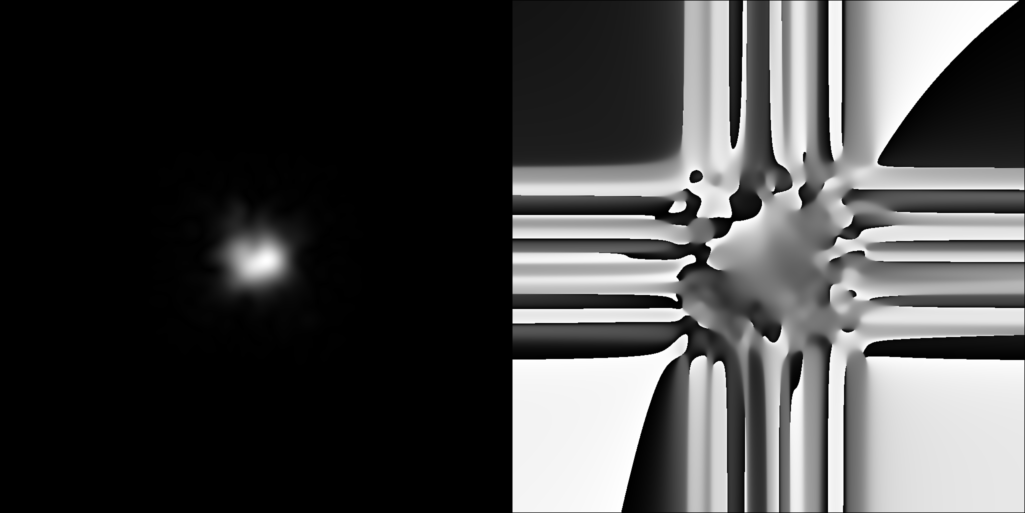

In [7]:
q = 1
a = 0.25
randAmp(n,m) = n==m==0 ? 1 : a*(randn() + im*randn())/(n^2+m^2)^q
nmas = Tuple((n,m,randAmp(n,m)) for n=0:20,m=0:20)
g = LF{ComplexAmp}(multimodeBeam(nmas,L0,0,1.5,1),L0)
look(g)

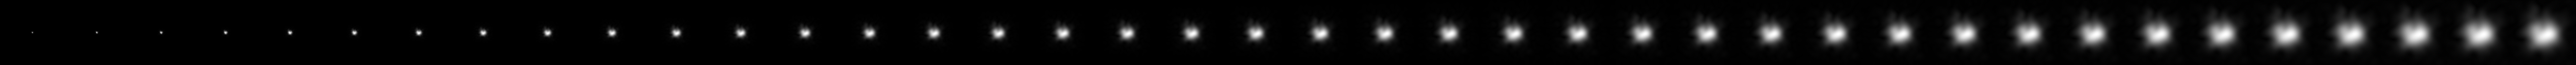

In [10]:
alphas = 0.1:0.1:4.0
phis = Tuple(LF{RealPhase}(α*r2(L0)/2,L0) for α in alphas)
divs = Tuple(sft(g * phi)|>abs for phi in phis)
look(divs...)

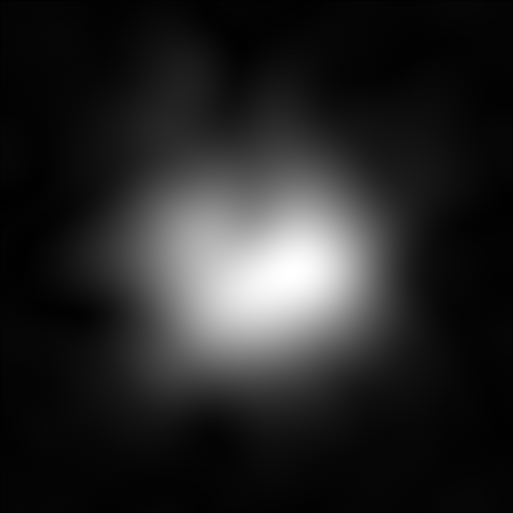

In [11]:
look(divs[end])

In [13]:
ws = [getWindowSize(divs[i],1-1e-3,910) for i=1:length(divs)];
etas = [boxEfficiency(divs[i],window(divs[i],ws[i])) for i=1:length(divs)];

In [14]:
ds = round.(Int,max.(ws ./ 100, 1));
ws = (ws .÷ ds) .* ds;

The next cell takes many hours to run.  

In [17]:
errs = zeros(length(divs),length(divs))
for j = 1:length(divs)
    for k = 1:length(divs)
        if j!=k
            guess = pdotBeamEstimate(downsample(square(divs[k])[window(divs[k],ws[k])],ds[k]),
                                    downsample(square(divs[j])[window(divs[j],ws[j])],ds[j]), 
                                    alphas[k],alphas[j], [0,0], [0,0], 0.001; LFine = L0);
            errs[j,k] = pdError(divs,phis,guess)
            println("Done with ",j,",",k,".  errs = ",errs[j,k])
        end
    end
end

Done with 1,2.  errs = 0.0014683580038753908
Done with 1,3.  errs = 0.0019224939153383149
Done with 1,4.  errs = 0.002129311965330709
Done with 1,5.  errs = 0.002243184119578156
Done with 1,6.  errs = 0.0023247927493710873
Done with 1,7.  errs = 0.00244041329270347
Done with 1,8.  errs = 0.0024945061132519895
Done with 1,9.  errs = 0.0025495141987920264
Done with 1,10.  errs = 0.0025947135550192907
Done with 1,11.  errs = 0.002660119481633244
Done with 1,12.  errs = 0.002692709220523513
Done with 1,13.  errs = 0.002722407631860502
Done with 1,14.  errs = 0.002749466863409091
Done with 1,15.  errs = 0.002790521392991787
Done with 1,16.  errs = 0.0028107713639948526
Done with 1,17.  errs = 0.0028294084017882887
Done with 1,18.  errs = 0.002846767416011929
Done with 1,19.  errs = 0.0028625704744139383
Done with 1,20.  errs = 0.0028883640643291826
Done with 1,21.  errs = 0.002903084405679983
Done with 1,22.  errs = 0.002911286619937879
Done with 1,23.  errs = 0.0029243127484330244
Done wit

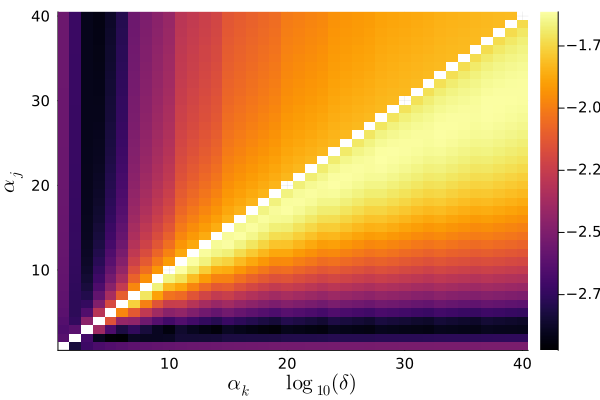

In [54]:
heatmap(log10.(errs),fontsize = 40,xlabel=L"\alpha_k \quad\quad \log_{10}(\delta)",ylabel=L"\alpha_j")

In [55]:
save("pdot-error-vs-alpha.png",heatmap(log10.(errs),fontsize = 40,xlabel=L"\alpha_k \quad\quad \log_{10}(\delta)",ylabel=L"\alpha_j"))

┌ Warning: Mapping to the storage type failed; perhaps your data had out-of-range values?
│ Try `map(clamp01nan, img)` to clamp values to a valid range.
└ @ ImageMagick C:\Users\stron\.julia\packages\ImageMagick\b8swT\src\ImageMagick.jl:180


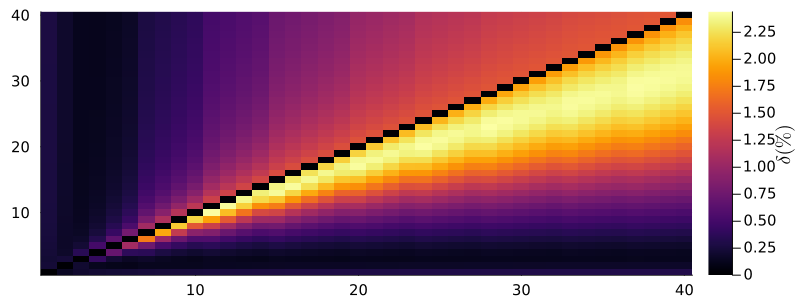

In [41]:
heatmap(errs*100,colorbar_title=L"\delta (\%)",size=(800,300))

In [26]:
save("pdot-error-vs-alpha.png",heatmap(log10.(errs),colorbar_title = L"\log_{10}(\delta)"))

┌ Warning: Mapping to the storage type failed; perhaps your data had out-of-range values?
│ Try `map(clamp01nan, img)` to clamp values to a valid range.
└ @ ImageMagick C:\Users\stron\.julia\packages\ImageMagick\b8swT\src\ImageMagick.jl:180


In [25]:
using LaTeXStrings

In [21]:
save("pdot-heatmap.jld2",Dict("errs"=>errs,"g"=>g,"alphas"=>alphas))